In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse 
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
import dask.dataframe as dd
from dask.dataframe import from_pandas
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from prettytable import PrettyTable

In [3]:
df=pd.read_csv('/content/drive/MyDrive/feature_extracted')

In [4]:
df_scraped=pd.read_csv('/content/drive/MyDrive/scraped_df')

In [5]:
columns=['length',
       'no_of_words', 'avg_word_length', 'caps', 'excl', 'sentence_count',
       'avg_sentence_length', 'sentiment', 'subjectivity', 'noun_count',
       'verb_count', 'adj_count', 'adv_count', 'pron_count']

In [6]:
identity_columns = ['asian',
       'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female',
       'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity',
       'other_religion', 'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']

In [7]:
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, 1, 0)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

df = convert_dataframe_to_bool(df)

In [8]:
df_non_toxic=df[df['target']==0].sample(frac=0.2)
df_toxic=df[df['target']==1]

In [9]:
df_new=pd.concat([df_toxic,df_non_toxic],axis=0)

In [10]:
Y=df_new['target']
X=df_new.drop(['target'],axis=1)

In [11]:
len(X)

471898

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42,stratify=Y, shuffle=True)

In [13]:
X_train=X_train[['clean_text','length',
       'no_of_words', 'avg_word_length', 'caps', 'excl', 'sentence_count',
       'avg_sentence_length', 'sentiment', 'subjectivity', 'noun_count',
       'verb_count', 'adj_count', 'adv_count', 'pron_count']]

In [14]:
X_scraped=df_scraped.drop(['Unnamed: 0', 'text', 'target'],axis=1)
Y_scraped=df_scraped['target']

In [15]:
X_train_scrapped=pd.concat([X_train,X_scraped],axis=0)

In [16]:
y_train_scraped=pd.concat([y_train,Y_scraped],axis=0)

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_vect = vectorizer.fit(X_train['clean_text'])

In [ ]:
vectorizer1 = TfidfVectorizer()
vectorizer1.fit(X_train_scrapped['clean_text'])

TfidfVectorizer()

In [17]:
import pickle
with open('/content/drive/MyDrive/glove.840B.300d.pkl', 'rb') as fp:
    glove = pickle.load(fp)
glove_words=glove.keys()

In [ ]:
dictionary=dict(zip(vectorizer.get_feature_names(),list(vectorizer.idf_)))
word_list=set(vectorizer.get_feature_names())
X_train_w2v=[]
count={0}
for sentence in tqdm(X_train['clean_text']):
    vector=np.zeros(300)    
    tfidf_weight=0    
    l=len(sentence.split())
    for word in sentence.split():
        if word in glove_words and word in word_list:
            count.add(word)
            vec=glove[word]               
            tfidf=dictionary[word]*(sentence.count(word)/l)            
            vector+=(vec*tfidf)            
            tfidf_weight+=tfidf
    if tfidf_weight !=0:
        vector/=tfidf_weight
    X_train_w2v.append(vector) 

In [ ]:
dictionary=dict(zip(vectorizer.get_feature_names(),list(vectorizer.idf_)))
word_list=set(vectorizer.get_feature_names())
X_test_w2v=[]
count={0}
for sentence in tqdm(X_test['clean_text']):
    vector=np.zeros(300)    
    tfidf_weight=0    
    l=len(sentence.split())
    for word in sentence.split():
        if word in glove_words and word in word_list:
            count.add(word)
            vec=glove[word]               
            tfidf=dictionary[word]*(sentence.count(word)/l)            
            vector+=(vec*tfidf)            
            tfidf_weight+=tfidf
    if tfidf_weight !=0:
        vector/=tfidf_weight
    X_test_w2v.append(vector)

100%|██████████| 165165/165165 [00:40<00:00, 4125.72it/s]


In [ ]:
parameters={'max_depth':[4,5,6,7,8]}
clf = HistGradientBoostingClassifier()
clf = GridSearchCV(clf, parameters,cv=5,scoring='roc_auc')
clf.fit(X_train_w2v,y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8]}, scoring='roc_auc')

In [ ]:
clf.best_estimator_

HistGradientBoostingClassifier(max_depth=7)

In [ ]:
clf = HistGradientBoostingClassifier(max_depth=7)
clf.fit(X_train_w2v,y_train)
Y_pred_tr=clf.predict_proba(X_train_w2v)

In [ ]:
Y_pred_te=clf.predict_proba(X_test_w2v)

In [ ]:
roc_auc_score(y_train, Y_pred_tr[:,1])

0.8737458734989059

In [ ]:
roc_auc_score(y_test, Y_pred_te[:,1])

0.8564822982455768

In [ ]:
Y_pred_te=clf.predict_proba(X_test_w2v)

In [ ]:
X_te_bias=X_test[identity_columns]
X_te_bias['y_pred']=Y_pred_te[:,1]
X_te_bias['y']=y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
identity_columns1=['latino','transgender','asian','psychiatric_or_mental_illness','jewish','homosexual_gay_or_lesbian',
                  'black','muslim','white','christian','male','female']

In [21]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup):
    subgroup_examples = df[df[subgroup]==1]
    return compute_auc(subgroup_examples['y'], subgroup_examples['y_pred'])

def compute_bpsn_auc(df, subgroup):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup]==1]
    subgroup_negative_examples = subgroup_negative_examples[subgroup_negative_examples['y']==0]
    non_subgroup_positive_examples = df[df[subgroup]==0]
    non_subgroup_positive_examples = non_subgroup_positive_examples[non_subgroup_positive_examples['y']==1]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples['y'], examples['y_pred'])

def compute_bnsp_auc(df, subgroup):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup]==1]
    subgroup_positive_examples = subgroup_positive_examples[subgroup_positive_examples['y']==1]
    non_subgroup_negative_examples = df[df[subgroup]==0]
    non_subgroup_negative_examples = non_subgroup_negative_examples[non_subgroup_negative_examples['y']==0]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples['y'], examples['y_pred'])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {'subgroup': subgroup,'subgroup_size': len(dataset[dataset[subgroup]==1])}
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_size', ascending=True)

In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(X_te_bias, identity_columns1)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,latino,246,0.814362,0.726606,0.906942
1,transgender,336,0.726870,0.745714,0.843739
2,asian,478,0.783865,0.762872,0.873998
3,psychiatric_or_mental_illness,634,0.777998,0.788042,0.850897
4,jewish,888,0.771024,0.700495,0.905522
5,homosexual_gay_or_lesbian,1605,0.728077,0.685156,0.890661
6,black,2332,0.718470,0.645256,0.901859
7,muslim,2799,0.735687,0.644767,0.915201
8,white,3789,0.739890,0.630131,0.919295
9,christian,3819,0.826721,0.825794,0.859672


In [22]:
def score(df,overall_auc):
    l=len(df)
    x=df.drop(['subgroup','subgroup_size'],axis=1)
    x=x.apply((lambda x: x**(-5)),axis=1)
    s=x.sum(axis=0)
    s=s.apply(lambda x: (x/l)**(1/(-5)))
    s=s.sum(axis=0)
    score=0.25*(s+overall_auc)
    return score    

In [ ]:
bias_score=score(bias_metrics_df,0.8576)
bias_score

0.8030411746534422

In [ ]:
from sklearn.linear_model import LogisticRegression
parameters={'C':[0.0001,0.001,0.01,1,10,100]}
clf = LogisticRegression(solver='saga',random_state=42)
clf = GridSearchCV(clf, parameters,cv=5,scoring='roc_auc')
clf.fit(X_train_w2v,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42, solver='saga'),
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 10, 100]},
             scoring='roc_auc')

In [ ]:
clf.best_estimator_

LogisticRegression(C=1, random_state=42, solver='saga')

In [ ]:
clf=LogisticRegression(C=1, random_state=42, solver='saga')
clf.fit(X_train_w2v,y_train)
Y_pred_tr=clf.predict_proba(X_train_w2v)

In [ ]:
Y_pred_te=clf.predict_proba(X_test_w2v)

In [ ]:
roc_auc_score(y_train, Y_pred_tr[:,1])

0.8547150453437975

In [ ]:
roc_auc_score(y_test, Y_pred_te[:,1])

0.8536722982629703

In [ ]:
Y_pred_te=clf.predict_proba(X_test_w2v)
X_te_bias=X_test[identity_columns]
X_te_bias['y_pred']=Y_pred_te[:,1]
X_te_bias['y']=y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(X_te_bias, identity_columns1)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,latino,246,0.798314,0.754518,0.881741
1,transgender,336,0.737520,0.750204,0.850610
2,asian,478,0.764138,0.775869,0.848931
3,psychiatric_or_mental_illness,634,0.762848,0.746944,0.868408
4,jewish,888,0.752704,0.709805,0.888251
5,homosexual_gay_or_lesbian,1605,0.735672,0.695151,0.886815
6,black,2332,0.740588,0.683280,0.892797
7,muslim,2799,0.732132,0.683701,0.891541
8,white,3789,0.743440,0.670221,0.901312
9,christian,3819,0.820711,0.847022,0.830273


In [ ]:
bias_score=score(bias_metrics_df,0.8521)
bias_score

0.8034781526695195

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters={'n_estimators':[10,20,30],'max_depth':[3,4,5,6],'max_samples':[0.4,0.5,0.7]}
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf = GridSearchCV(clf, parameters,cv=5,scoring='roc_auc')
clf.fit(X_train_w2v,y_train)

In [ ]:
clf.best_estimator_

RandomForestClassifier(max_depth=6, max_samples=0.4, n_estimators=30, n_jobs=-1,
                       random_state=0)

In [ ]:
clf=RandomForestClassifier(max_depth=6, max_samples=0.4, n_estimators=30, n_jobs=-1,
                       random_state=0)
clf.fit(X_train_w2v,y_train)
Y_pred_tr=clf.predict_proba(X_train_w2v)

In [ ]:
Y_pred_te=clf.predict_proba(X_test_w2v)

In [ ]:
roc_auc_score(y_train, Y_pred_tr[:,1])

0.8165089385303973

In [ ]:
roc_auc_score(y_test, Y_pred_te[:,1])

0.8097501889546995

In [ ]:
Y_pred_te=clf.predict_proba(X_test_w2v)
X_te_bias=X_test[identity_columns]
X_te_bias['y_pred']=Y_pred_te[:,1]
X_te_bias['y']=y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(X_te_bias, identity_columns1)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,latino,245,0.763230,0.668504,0.884667
1,transgender,340,0.727344,0.781446,0.762993
2,asian,514,0.742505,0.733849,0.818869
3,psychiatric_or_mental_illness,639,0.805775,0.830321,0.784712
4,jewish,899,0.732394,0.612696,0.891894
5,homosexual_gay_or_lesbian,1581,0.723626,0.671915,0.854462
6,black,2353,0.703127,0.633883,0.861104
7,muslim,2810,0.709023,0.590273,0.892805
8,white,3736,0.712274,0.597909,0.886143
9,christian,3785,0.797961,0.756562,0.845823


In [ ]:
bias_score=score(bias_metrics_df,0.8521)
bias_score

0.7760749490172429

In [ ]:
dictionary=dict(zip(vectorizer1.get_feature_names(),list(vectorizer1.idf_)))
word_list=set(vectorizer1.get_feature_names())
X_train_scraped_w2v=[]
count={0}
for sentence in tqdm(X_train_scrapped['clean_text']):
    vector=np.zeros(300)    
    tfidf_weight=0    
    l=len(sentence.split())
    for word in sentence.split():
        if word in glove_words and word in word_list:
            count.add(word)
            vec=glove[word]               
            tfidf=dictionary[word]*(sentence.count(word)/l)            
            vector+=(vec*tfidf)            
            tfidf_weight+=tfidf
    if tfidf_weight !=0:
        vector/=tfidf_weight
    X_train_scraped_w2v.append(vector)  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 320871/320871 [01:17<00:00, 4148.58it/s]


In [ ]:
dictionary=dict(zip(vectorizer1.get_feature_names(),list(vectorizer1.idf_)))
word_list=set(vectorizer1.get_feature_names())
X_test_scraped_w2v=[]
count={0}
for sentence in tqdm(X_test['clean_text']):
    vector=np.zeros(300)    
    tfidf_weight=0    
    l=len(sentence.split())
    for word in sentence.split():
        if word in glove_words and word in word_list:
            count.add(word)
            vec=glove[word]               
            tfidf=dictionary[word]*(sentence.count(word)/l)            
            vector+=(vec*tfidf)            
            tfidf_weight+=tfidf
    if tfidf_weight !=0:
        vector/=tfidf_weight
    X_test_scraped_w2v.append(vector) 

100%|██████████| 165165/165165 [00:39<00:00, 4189.33it/s]


In [ ]:
parameters={'max_depth':[4,5,6,7,8]}
clf = HistGradientBoostingClassifier()
clf = GridSearchCV(clf, parameters,cv=5,scoring='roc_auc')
clf.fit(X_train_scraped_w2v,y_train_scraped)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8]}, scoring='roc_auc')

In [ ]:
clf.best_estimator_

HistGradientBoostingClassifier(max_depth=8)

In [ ]:
clf = HistGradientBoostingClassifier(max_depth=8)
clf.fit(X_train_scraped_w2v,y_train_scraped)
Y_pred_tr=clf.predict_proba(X_train_scraped_w2v)

In [ ]:
Y_pred_te=clf.predict_proba(X_test_scraped_w2v)

In [ ]:
roc_auc_score(y_train_scraped, Y_pred_tr[:,1])

0.8827457462430206

In [ ]:
roc_auc_score(y_test, Y_pred_te[:,1])

0.8520936277352503

In [ ]:
X_te_bias=X_test_scraped[identity_columns]
X_te_bias['y_pred']=Y_pred_te[:,1]
X_te_bias['y']=y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(X_te_bias, identity_columns1)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,latino,198,0.759318,0.710047,0.890941
1,transgender,254,0.735246,0.814572,0.783749
2,asian,332,0.795904,0.779590,0.868160
3,psychiatric_or_mental_illness,502,0.756110,0.801848,0.815547
4,jewish,647,0.747204,0.720878,0.874166
5,homosexual_gay_or_lesbian,1339,0.715342,0.733147,0.845361
6,black,2034,0.713714,0.647084,0.894949
7,muslim,2221,0.742333,0.677204,0.895699
9,christian,2554,0.822677,0.850253,0.825847
8,white,3055,0.719175,0.632638,0.903999


In [ ]:
bias_score=score(bias_metrics_df,0.852)
bias_score

0.7969099640313553

In [ ]:
from sklearn.linear_model import LogisticRegression
parameters={'C':[0.0001,0.001,0.01,1,10,100]}
clf = LogisticRegression(solver='saga',random_state=42)
clf = GridSearchCV(clf, parameters,cv=5,scoring='roc_auc')
clf.fit(X_train_scraped_w2v,y_train_scraped)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42, solver='saga'),
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 10, 100]},
             scoring='roc_auc')

In [ ]:
clf.best_estimator_

LogisticRegression(C=1, random_state=42, solver='saga')

In [ ]:
clf=LogisticRegression(C=1, random_state=42, solver='saga')
clf.fit(X_train_scraped_w2v,y_train_scraped)
Y_pred_tr=clf.predict_proba(X_train_scraped_w2v)

In [ ]:
Y_pred_te=clf.predict_proba(X_test_scraped_w2v)

In [ ]:
roc_auc_score(y_train_scraped, Y_pred_tr[:,1])

0.8565867798764764

In [ ]:
roc_auc_score(y_test, Y_pred_te[:,1])

0.8510600862512072

In [ ]:
X_te_bias=X_test[identity_columns]
X_te_bias['y_pred']=Y_pred_te[:,1]
X_te_bias['y']=y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(X_te_bias, identity_columns1)
bias_metrics_df

NameError: ignored

In [ ]:
bias_score=score(bias_metrics_df,0.851)
bias_score

0.8102160379072746

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters={'n_estimators':[10,20,30],'max_depth':[3,4,5,6],'max_samples':[0.4,0.5,0.7]}
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf = GridSearchCV(clf, parameters,cv=5,scoring='roc_auc')
clf.fit(X_train_scraped_w2v,y_train_scraped)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_samples': [0.4, 0.5, 0.7],
                         'n_estimators': [10, 20, 30]},
             scoring='roc_auc')

In [ ]:
clf.best_estimator_

RandomForestClassifier(max_depth=6, max_samples=0.5, n_estimators=30, n_jobs=-1,
                       random_state=0)

In [ ]:
clf=RandomForestClassifier(max_depth=6, max_samples=0.5, n_estimators=30, n_jobs=-1,
                       random_state=0)
clf.fit(X_train_scraped_w2v,y_train_scraped)
Y_pred_tr=clf.predict_proba(X_train_scraped_w2v)

In [ ]:
Y_pred_te=clf.predict_proba(X_test_scraped_w2v)

In [ ]:
roc_auc_score(y_train_scraped, Y_pred_tr[:,1])

0.8224430145048388

In [ ]:
roc_auc_score(y_test, Y_pred_te[:,1])

0.8116417374113483

In [ ]:
X_te_bias=X_test[identity_columns]
X_te_bias['y_pred']=Y_pred_te[:,1]
X_te_bias['y']=y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(X_te_bias, identity_columns1)
bias_metrics_df

In [ ]:
bias_score=score(bias_metrics_df,0.81164)
bias_score

0.765481959446413

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(
    num_words=None,
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None
)
tokenizer.fit_on_texts(
    X_train['clean_text']
)

In [ ]:
X_tr=tokenizer.texts_to_sequences(X_train['clean_text'])
X_te=tokenizer.texts_to_sequences(X_test['clean_text'])

In [ ]:
X_tr=tf.keras.preprocessing.sequence.pad_sequences(X_tr,maxlen=500,truncating='post',dtype='int32',padding='post',value=0)
X_te=tf.keras.preprocessing.sequence.pad_sequences(X_te,maxlen=500,truncating='post',dtype='int32',padding='post',value=0)

In [ ]:
v=0
vocab_size=len(tokenizer.word_index) + 1
embedding_matrix=np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    embedding_vector=glove.get(word)
    if embedding_vector is not None:
        v=v+1
        embedding_matrix[i]=embedding_vector

In [ ]:
v

71293

In [ ]:
vocab_size=len(tokenizer.word_index) + 1
vocab_size

In [ ]:
v/vocab_size

0.5283663502086251

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_auc', min_delta=0.002, patience=2, verbose=1)
call=[earlystop]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
input_layer = Input(shape=(500))
embd=tf.keras.layers.Embedding(vocab_size,300,
                               weights=[embedding_matrix],
                               input_length=500,trainable=False)(input_layer)
dr1=tf.keras.layers.Dropout(0.2)(embd)
lstm=tf.keras.layers.LSTM(100)(dr1)
output_layer=tf.keras.layers.Dense(1,activation='sigmoid')(lstm)     

model = Model(inputs=input_layer, outputs=output_layer)


## defining the optimiser and loss function
ad=tf.keras.optimizers.Adam(
    learning_rate=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)
model.compile(optimizer=ad,
              loss='BinaryCrossentropy',
              metrics=['AUC'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 300)          40479300  
                                                                 
 dropout_1 (Dropout)         (None, 500, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,639,801
Trainable params: 160,501
Non-trainable params: 40,479,300
_________________________________________________________________


In [ ]:
model.fit(X_tr, y_train, epochs=30, batch_size=128, validation_data=(X_te,y_test),callbacks=call)

Epoch 1/30
2397/2397 [==============================] - 124s 51ms/step - loss: 0.5869 - auc: 0.6382 - val_loss: 0.5346 - val_auc: 0.8092
Epoch 2/30
2397/2397 [==============================] - 121s 50ms/step - loss: 0.5048 - auc: 0.7856 - val_loss: 0.4699 - val_auc: 0.8291
Epoch 3/30
2397/2397 [==============================] - 121s 50ms/step - loss: 0.4675 - auc: 0.8031 - val_loss: 0.4526 - val_auc: 0.8264
Epoch 4/30
2397/2397 [==============================] - 121s 50ms/step - loss: 0.4576 - auc: 0.8127 - val_loss: 0.4442 - val_auc: 0.8452
Epoch 5/30
2397/2397 [==============================] - 121s 50ms/step - loss: 0.4469 - auc: 0.8252 - val_loss: 0.4322 - val_auc: 0.8482
Epoch 6/30
2397/2397 [==============================] - 121s 50ms/step - loss: 0.4318 - auc: 0.8486 - val_loss: 0.4058 - val_auc: 0.8788
Epoch 7/30
2397/2397 [==============================] - 121s 50ms/step - loss: 0.3965 - auc: 0.8769 - val_loss: 0.3787 - val_auc: 0.8930
Epoch 8/30
2397/2397 [===================

In [ ]:
model.save("model1.h5")

In [ ]:
model = load_model('model.h5')

In [ ]:
y_pred=model.predict(X_te)

In [ ]:
X_te_bias=X_test[identity_columns]
X_te_bias['y_pred']=y_pred
X_te_bias['y']=y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(X_te_bias, identity_columns1)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,latino,261,0.865369,0.837475,0.947156
1,transgender,343,0.804145,0.840205,0.911074
2,asian,471,0.866587,0.870125,0.928329
3,psychiatric_or_mental_illness,620,0.817303,0.838523,0.927871
4,jewish,872,0.827070,0.825502,0.936577
5,homosexual_gay_or_lesbian,1610,0.787208,0.766858,0.947044
6,black,2325,0.781049,0.720229,0.957431
7,muslim,2788,0.783101,0.773759,0.944732
8,white,3699,0.796806,0.726613,0.960554
9,christian,3729,0.896454,0.909765,0.921813


In [ ]:
bias_score=score(bias_metrics_df,0.9312)
bias_score

0.8753098825008193

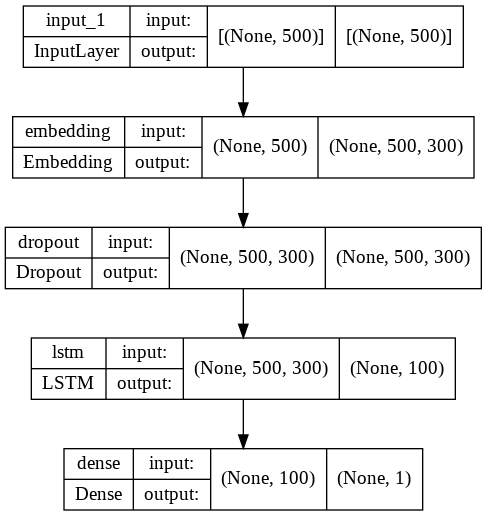

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
tokenizer1=Tokenizer(
    num_words=None,
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None
)
tokenizer1.fit_on_texts(
    X_train_scrapped['clean_text']
)

In [24]:
X_tr=tokenizer1.texts_to_sequences(X_train_scrapped['clean_text'])
X_te=tokenizer1.texts_to_sequences(X_test['clean_text'])

In [25]:
X_tr=tf.keras.preprocessing.sequence.pad_sequences(X_tr,maxlen=500,truncating='post',dtype='int32',padding='post',value=0)
X_te=tf.keras.preprocessing.sequence.pad_sequences(X_te,maxlen=500,truncating='post',dtype='int32',padding='post',value=0)

In [26]:
v=0
vocab_size=len(tokenizer1.word_index) + 1
embedding_matrix=np.zeros((vocab_size,300))
for word, i in tokenizer1.word_index.items():
    embedding_vector=glove.get(word)
    if embedding_vector is not None:
        v=v+1
        embedding_matrix[i]=embedding_vector

In [ ]:
vocab_size=len(tokenizer1.word_index) + 1
vocab_size

144173

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_auc', min_delta=0.002, patience=2, verbose=1)
call=[earlystop]

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
input_layer = Input(shape=(500))
embd=tf.keras.layers.Embedding(vocab_size,300,
                               weights=[embedding_matrix],
                               input_length=500,trainable=False)(input_layer)
dr1=tf.keras.layers.Dropout(0.2)(embd)
lstm=tf.keras.layers.LSTM(100)(dr1)
output_layer=tf.keras.layers.Dense(1,activation='sigmoid')(lstm)     

model = Model(inputs=input_layer, outputs=output_layer)


## defining the optimiser and loss function
ad=tf.keras.optimizers.Adam(
    learning_rate=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)
model.compile(optimizer=ad,
              loss='BinaryCrossentropy',
              metrics=['AUC'])

In [29]:
model.fit(X_tr, y_train_scraped, epochs=30, batch_size=128, validation_data=(X_te,y_test),callbacks=call)

Epoch 1/30
2507/2507 [==============================] - 135s 51ms/step - loss: 0.5660 - auc: 0.6615 - val_loss: 0.5302 - val_auc: 0.8113
Epoch 2/30
2507/2507 [==============================] - 131s 52ms/step - loss: 0.4927 - auc: 0.7972 - val_loss: 0.4843 - val_auc: 0.8194
Epoch 3/30
2507/2507 [==============================] - 130s 52ms/step - loss: 0.4602 - auc: 0.8083 - val_loss: 0.4612 - val_auc: 0.8281
Epoch 4/30
2507/2507 [==============================] - 130s 52ms/step - loss: 0.4486 - auc: 0.8159 - val_loss: 0.4519 - val_auc: 0.8327
Epoch 5/30
2507/2507 [==============================] - 130s 52ms/step - loss: 0.4403 - auc: 0.8216 - val_loss: 0.4438 - val_auc: 0.8435
Epoch 6/30
2507/2507 [==============================] - 130s 52ms/step - loss: 0.4297 - auc: 0.8372 - val_loss: 0.4279 - val_auc: 0.8590
Epoch 7/30
2507/2507 [==============================] - 130s 52ms/step - loss: 0.3982 - auc: 0.8706 - val_loss: 0.3862 - val_auc: 0.8869
Epoch 8/30
2507/2507 [===================

In [33]:
y_pred=model.predict(X_te)

In [34]:
X_te_bias=X_test[identity_columns]
X_te_bias['y_pred']=y_pred
X_te_bias['y']=y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
bias_metrics_df = compute_bias_metrics_for_model(X_te_bias, identity_columns1)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,latino,237,0.866716,0.864387,0.934986
1,transgender,323,0.800000,0.874169,0.881256
2,asian,471,0.876279,0.876054,0.930169
3,psychiatric_or_mental_illness,633,0.844020,0.872828,0.915835
4,jewish,902,0.853292,0.856343,0.932117
5,homosexual_gay_or_lesbian,1610,0.797670,0.815783,0.928995
6,black,2347,0.765868,0.720476,0.953066
7,muslim,2754,0.791179,0.794203,0.937989
8,white,3687,0.792136,0.733934,0.957238
9,christian,3803,0.897101,0.916512,0.914917


In [36]:
bias_score=score(bias_metrics_df,0.9302)
bias_score

0.8784112123291041

In [ ]:
x = PrettyTable()
x.field_names = ['Feature',"Train AUC", "Test AUC", "Bias_Score"]
x.add_rows(
    [
        ["LSTM", 0.8827, 0.8551, 0.8054],
        ["LSTM with scraped data",  0.8742, 0.8520, 0.7969],    
        ["Logistic Regression", 0.8541, 0.8522, 0.8057],
        ["LR with scraped data",  0.8566, 0.8511, 0.8102],  
        ["Random Forest", 0.8165, 0.8097, 0.7760],
        ["RF with scraped data",  0.8224, 0.8116, 0.7654]        
    ]
)

In [38]:
x = PrettyTable()
x.field_names = ['Feature',"Train AUC", "Test AUC", "Bias_Score"]
x.add_rows(
    [
        ["GBDT", 0.8827, 0.8551, 0.8054],
        ["GBDT with scraped data",  0.8742, 0.8520, 0.7969],    
        ["Logistic Regression", 0.8541, 0.8522, 0.8057],
        ["LR with scraped data",  0.8566, 0.8511, 0.8102],  
        ["Random Forest", 0.8165, 0.8097, 0.7760],
        ["RF with scraped data",  0.8224, 0.8116, 0.7654],  
        ["LSTM", 0.9241, 0.9312, 0.8753],
        ["LSTM with scraped data",  0.9275, 0.9302, 0.8784],      
    ]
)

In [40]:
print(x)

+------------------------+-----------+----------+------------+
|        Feature         | Train AUC | Test AUC | Bias_Score |
+------------------------+-----------+----------+------------+
|          GBDT          |   0.8827  |  0.8551  |   0.8054   |
| GBDT with scraped data |   0.8742  |  0.852   |   0.7969   |
|  Logistic Regression   |   0.8541  |  0.8522  |   0.8057   |
|  LR with scraped data  |   0.8566  |  0.8511  |   0.8102   |
|     Random Forest      |   0.8165  |  0.8097  |   0.776    |
|  RF with scraped data  |   0.8224  |  0.8116  |   0.7654   |
|          LSTM          |   0.9241  |  0.9312  |   0.8753   |
| LSTM with scraped data |   0.9275  |  0.9302  |   0.8784   |
+------------------------+-----------+----------+------------+
